In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as signal
import random
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import utils
import h5py
import time
from sklearn.preprocessing import MinMaxScaler

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
'''
Based on work by Federico De Guio: https://github.com/deguio/ML4DQM/blob/master/notebooks/Semi_Supervised/AE_ssl_random_hotdead_size.ipynb
See: https://indico.cern.ch/event/783825/contributions/3261553/attachments/1789464/2914642/hcaldpg_fpga_ml_reco_01feb2019.pdf
for possible implementation into FPGA
'''

Using TensorFlow backend.


'\nBased on work by Federico De Guio: https://github.com/deguio/ML4DQM/blob/master/notebooks/Semi_Supervised/AE_ssl_random_hotdead_size.ipynb\nSee: https://indico.cern.ch/event/783825/contributions/3261553/attachments/1789464/2914642/hcaldpg_fpga_ml_reco_01feb2019.pdf\nfor possible implementation into FPGA\n'

In [4]:
def plot_loss(data, title,yscale="linear"):     
    """ Plots the training and validation loss yscale can be: linear,log,symlog """
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data.history["loss"])#, linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data.history["val_loss"])#, linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"])#, loc="upper right", frameon=False)
    plt.yscale(yscale)
    plt.show();

In [5]:
class Pulse:
    '''
    A class that generates a Pulse that includes both Cerenkov and Scintillation Pulse. The pulse is randomly generated 
    through the use of a probability density function that is generated by the given parameters.
    The pulse has 512 samples and is identifiable by 3 parameters:
        1) ratio: If ratio is positive, it is the ratio of the Area of Cernekov:Area of Scintillation. 
                  If ratio is negative, it is the ratio of the Area of Scintillation:Area of Cerenkov
                
        This is altered by changing the height of the Cerenkov pulse (Cerenkov Radiation).
        
        
        2) separation: Time between the two pulses
       
    '''
    
    
    
    def __init__(self,ratio, scint_decay):
        self.start=10
        self.rise=0.05
        self.cerenkov_decay=2.5
        self.scint_decay=scint_decay
        
        self.end_time=250
        self.timesteps=100
        self.t=np.linspace(0,self.end_time,self.timesteps)
        self.bin_number=100
        

        if ratio>0:
            self.ratio=ratio
        else:
            self.ratio=-(1/ratio)
            
        
        self.cerenkov_strength=self.ratio
        #self.cerenkov_percent=self.ratio/(self.ratio+1)
        #self.scint_percent=1/(self.ratio+1)
        #self.interp=self.interpolator()
        self.cerenkov_area=sp.integrate.quad(self.cerenkov_scaled, self.start, self.end_time)
        self.scint_area=sp.integrate.quad(self.scintillation_normalized, self.start, self.end_time)
        
        self.cerenkov_percent=(self.cerenkov_area[0])/(self.cerenkov_area[0]+self.scint_area[0])
        self.scint_percent=(self.scint_area[0])/(self.cerenkov_area[0]+self.scint_area[0])
 
    def cerenkov(self,t):
        return (1-np.exp(-((t-self.start)/self.rise)))*(np.exp(-((t-self.start)/self.cerenkov_decay)))

    def scintillation(self, t):
        return (1-np.exp(-((t-self.start)/self.rise)))*(np.exp(-((t-self.start)/self.scint_decay)))
    
    def cerenkov_scaled(self, t):
        cerenkov=self.cerenkov(t)
        norm=sp.integrate.quad(self.cerenkov, self.start, self.end_time)
        return (1/norm[0])*self.cerenkov_strength*cerenkov
    
    def scintillation_normalized(self, t):
        scint=self.scintillation(t)
        norm=sp.integrate.quad(self.scintillation, self.start, self.end_time)
        return (1/norm[0])*scint


    def pulse_func_helper(self, time):
        if time<self.start:
            return 0
        else:
            return self.cerenkov_scaled(time) + self.scintillation_normalized(time) 
    
    
    def pulse_func(self, t):
        pulse=[]
                        
        for time in t:
            pulse.append(self.pulse_func_helper(time))
        return np.asarray(pulse)


    def randomValues(self,number):
        val=[]
        for x in range(number):
            val.append(random.random())
        return val

    
    def graph_both_pulses(self):
        t=np.arange(self.start,self.end_time,self.timestep)
        plt.figure()
        plt.plot(t, self.cerenkov_scaled(t), c='r', label="cerenkov")
        plt.plot(t, self.scintillation_normalized(t), label='scintillation')
        plt.xlabel("Time (ns)")
        plt.title("Pulse with ratio "+ str(self.ratio)+ " and scint decay "+str(self.scint_decay))
        plt.legend()
    
    def final_pdf(self, t):
        radiation=self.pulse_func(t)
        norm=np.trapz(radiation, self.t)
        return (1/norm)*radiation
    
    def graph_pdf(self):
        plt.figure()
        plt.plot(self.t, self.final_pdf(self.t))
        plt.xlabel("Time (ns)")
        plt.title("Pulse with ratio "+ str(self.ratio)+ " and scint decay "+str(self.scint_decay))

    
    def output(self):
        vals=self.final_pdf(self.t)
        vals_max=max(vals)
        output=vals*(1/vals_max)
        return output, self.cerenkov_percent, self.scint_percent
        
        #return vals, self.cerenkov_percent, self.scint_percent

    
    '''
    DEPRECAYED FUNCTIONS
    def final_distribution(self):
        cumul=self.final_cdf(self.t)
        hits=self.photoelectrons
        #print(hits)
        rand=self.randomValues(hits)
        #print(rand)
        interp=sp.interpolate.interp1d(cumul,self.t, fill_value="extrapolate")
        vals=interp(rand)
        #print(vals)
        return vals
        
    def histogram_generator(self):
        data=self.final_distribution()
        hist, bin_edges=np.histogram(data, bins=self.bin_number, range=(0,self.end_time))
        #print(bin_edges)
        return hist
    
    def output(self):
        
        
        return self.histogram_generator(), self.cerenkov_percent, self.scint_percent
    '''
    


In [6]:
class PulseLibrary:
    '''
    Creates a list of pulses with the attached ratio.
    labels has form of ratioXXXscint_decayXXeventXX
    '''
    
    def __init__(self, seed, name, ratios=[1],scint_decays=[50]):
        np.random.seed(seed)
        self.name=name +'.hdf5'
        self.scint_decays=scint_decays
        self.ratios=ratios
        
        self.labels=[]
        self.pulses=[]
        self.inputs=[]
        self.outputs=[]
        
        
        
        file=h5py.File(self.name, 'w')
        
        for ratio in self.ratios:
            for scint_decay in self.scint_decays:
                pulse=Pulse( ratio, scint_decay)
                
                group_name="ratio"+str(ratio)+"scintdecay"+str(scint_decay)
                
                group = file.create_group(group_name)
                
                
                    
                self.pulses.append(pulse)
                ins, out1, out2=pulse.output()
                outs=[out1, out2]
                 
                 
                label="ratio"+str(ratio)+"scintdecay"+str(scint_decay)
                self.labels.append(label)
                self.inputs.append(ins)
                self.outputs.append(outs)
                 
                subgroup=group.create_group(label)
                    
                    
                d1 = subgroup.create_dataset(label+'input', data=ins)
                d2 = subgroup.create_dataset(label+'output', data=outs)
                    
        
        file.close()
    
    def get_inputs(self):
        return np.asarray(self.inputs)
    
    def get_outputs(self):
        return np.asarray(self.outputs)
    
    def get_labels(self):
        return self.labels
    
    def get_pulses(self):
        return np.asarray(self.pulses)

In [13]:
pulse=Pulse(10,25)

In [14]:
a,b,c=pulse.output()

15.286179730100336


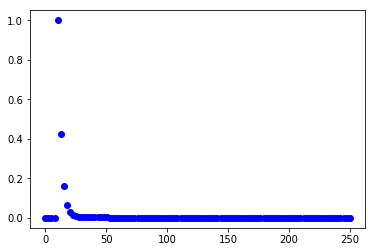

In [15]:


pulse_func=pulse.pulse_func(pulse.t)
plt.plot(pulse.t, a, 'bo')
print(np.trapz(pulse.pulse_func(pulse.t),pulse.t))

norm=sp.integrate.quad(pulse.pulse_func_helper, 0, pulse.end_time)

In [93]:
pulse_func_normalized=pulse_func/norm[0]
print(len(pulse_func))
print(len(pulse.t))

100
100


In [103]:

np.trapz(pulse.final_pdf(pulse.t), pulse.t)

np.cumsum(a)*2.52525253

array([0.        , 0.        , 0.        , 0.        , 0.5671867 ,
       0.80889027, 0.90013196, 0.93626898, 0.95205844, 0.96018509,
       0.96529277, 0.96909461, 0.97223433, 0.9749643 , 0.97739261,
       0.97957328, 0.98153921, 0.98331437, 0.98491829, 0.98636785,
       0.98767805, 0.98886234, 0.98993284, 0.99090048, 0.99177516,
       0.9925658 , 0.99328047, 0.99392649, 0.99451043, 0.99503828,
       0.99551541, 0.9959467 , 0.99633655, 0.99668895, 0.99700749,
       0.99729542, 0.99755569, 0.99779096, 0.99800362, 0.99819585,
       0.99836962, 0.99852669, 0.99866866, 0.998797  , 0.99891301,
       0.99901787, 0.99911265, 0.99919833, 0.99927578, 0.99934579,
       0.99940907, 0.99946627, 0.99951798, 0.99956472, 0.99960696,
       0.99964515, 0.99967967, 0.99971087, 0.99973908, 0.99976457,
       0.99978762, 0.99980845, 0.99982728, 0.9998443 , 0.99985969,
       0.9998736 , 0.99988617, 0.99989753, 0.9999078 , 0.99991709,
       0.99992548, 0.99993307, 0.99993993, 0.99994612, 0.99995

In [10]:
def model_creator():
    model = Sequential()
    #model.add(Dense(50,  input_shape=(100,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(10,  input_shape=(100,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='relu'))
# Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def model_trainer(pulse_library, model_name):
    model=model_creator()
    file=h5py.File(pulse_library, 'r')
    X=[]
    Y=[]
    for groups in file.values():
        for subgroup in groups.values():
            for event in subgroup.values():

                if event.name[-5:]=="input":
                    X.append(event[:])
                    #data=event[:]
                    #data=np.asarray(data)
                    #norm_factor=max(data)
                    #data_normalized=data/norm_factor
                    #X.append(data_normalized)
                elif event.name[-6:]=="output":
                    Y.append(event[:])
    file.close()    
    X=np.asarray(X)

    Y=np.asarray(Y)
    norm_factor=np.amax(X)
    X_scaled=X/norm_factor
    print(np.amax(X_scaled))
    Xtrain, Xval, Ytrain, Yval = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
    #Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=42)
    #checkpointer = ModelCheckpoint(filepath=model_name+"weights.hdf5",verbose=3, save_best_only=True)
    earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=100 ,verbose=1, mode='auto')
    history=model.fit(Xtrain,Ytrain,epochs=700,verbose=1
                             ,validation_data=(Xval,Yval)
                             ,shuffle=True, batch_size=32
                             ,callbacks=[earlystop])
    model.save(model_name)
    return model, history

def model_verifier(pulse_library, model_name, ratios, scint_decays):
    model=load_model(model_name)
    file=h5py.File(pulse_library, 'r')
    X=[]
    Y=[]
    labels=[]
    
    for ratio in ratios:
        for scint_decay in scint_decays:
            tempX=[]
            tempY=[]
            templabels=[]
            
            label="/ratio"+str(ratio)+"scintdecay"+str(scint_decay)+"/ratio"+str(ratio)+"scintdecay"+str(scint_decay)+"/ratio"+str(ratio)+"scintdecay"+str(scint_decay)
                #print(label)
            Xdata=file[label+"input"][:]
            Ydata=file[label+"output"][:]
            #Xdata=np.asarray(Xdata)
            #norm_factor=max(Xdata)
            #norm_factor=np.trapz(Xdata, dx=2.5252525)
            #Xdata_normalized=Xdata/norm_factor
            #tempX.append(Xdata_normalized)
            tempX.append(Xdata)
            tempY.append(Ydata)
            templabels.append(label)
            X.append(tempX)
            Y.append(tempY)
            labels.append(templabels)
    
    file.close()
    X=np.asarray(X)
    Y=np.asarray(Y)
    norm_factor=np.amax(X)
    X_scaled=X/norm_factor
    results=[]
    for x in X_scaled:
        prediction=model.predict(x)
        results.append(prediction)

    results=np.array(results)
    #results=model.predict(X)
    return results, Y, labels
    
    
    '''
    deprecated
    for groups in file.values():
        tempX=[]
        tempY=[]
        templabels=[]
        for subgroup in groups.values():
            
            for event in subgroup.values():
                if event.name[-5:]=="input":
                    tempX.append(event)
                    templabels.append(event.name)
                elif event.name[-6:]=="output":
                    tempY.append(event)
        X.append(tempX)
        Y.append(tempY)
        labels.append(templabels)
            
    X=np.asarray(X)
    Y=np.asarray(Y)
    results=[]
    for x in X:
        prediction=model.predict(x)
        results.append(prediction)
    results=np.array(results)
    #results=model.predict(X)
    return results, Y, labels
    '''

In [11]:
training_seed=7
testing_seed=8
nn1_scint_decays_train=np.linspace(15,50,100)
nn1_ratios_train=np.linspace(-25,25,100)


nn1_scint_decays_test=np.linspace(15,50,20)
nn1_ratios_test=np.linspace(-25,25,20)






In [12]:

#train_library2=PulseLibrary(training_seed,"PDFsOnlyTestingLibrary_100x100_normalized_max", nn1_ratios_train, nn1_scint_decays_train)
#test_library2=PulseLibrary(testing_seed,"PDfsOnlyTestingLibrary_20x20_normalized_max", nn1_ratios_test, nn1_scint_decays_test)


In [13]:
nn1_scint_decays_test=np.linspace(15,50,10)
nn1_ratios_test=np.linspace(-25,25,10)





#test_library2=PulseLibrary(testing_seed,"PDfsOnlyTestingLibrary_10x10", nn1_ratios_test, nn1_scint_decays_test)

1.0
Train on 8000 samples, validate on 2000 samples
Epoch 1/700
8000/8000 [==============================] - 1s 131us/step - loss: 0.2130 - val_loss: 0.0962
Epoch 2/700
8000/8000 [==============================] - 1s 66us/step - loss: 0.0425 - val_loss: 0.0090
Epoch 3/700
8000/8000 [==============================] - 0s 52us/step - loss: 0.0031 - val_loss: 0.0010
Epoch 4/700
8000/8000 [==============================] - 1s 72us/step - loss: 8.3829e-04 - val_loss: 6.7573e-04
Epoch 5/700
8000/8000 [==============================] - 0s 55us/step - loss: 6.4957e-04 - val_loss: 5.6266e-04
Epoch 6/700
8000/8000 [==============================] - 0s 61us/step - loss: 5.4346e-04 - val_loss: 4.8485e-04
Epoch 7/700
8000/8000 [==============================] - 0s 56us/step - loss: 4.6262e-04 - val_loss: 4.1434e-04
Epoch 8/700
8000/8000 [==============================] - 0s 54us/step - loss: 4.0281e-04 - val_loss: 3.7015e-04
Epoch 9/700
8000/8000 [==============================] - 0s 59us/step - los

8000/8000 [==============================] - 0s 48us/step - loss: 2.1364e-04 - val_loss: 2.0868e-04
Epoch 74/700
8000/8000 [==============================] - 1s 81us/step - loss: 2.0973e-04 - val_loss: 2.0511e-04
Epoch 75/700
8000/8000 [==============================] - 1s 73us/step - loss: 2.0775e-04 - val_loss: 2.0157e-04
Epoch 76/700
8000/8000 [==============================] - 0s 45us/step - loss: 2.0543e-04 - val_loss: 2.0612e-04
Epoch 77/700
8000/8000 [==============================] - 1s 77us/step - loss: 1.9991e-04 - val_loss: 2.0136e-04
Epoch 78/700
8000/8000 [==============================] - 1s 70us/step - loss: 1.9565e-04 - val_loss: 1.9167e-04
Epoch 79/700
8000/8000 [==============================] - 1s 70us/step - loss: 1.9200e-04 - val_loss: 1.9082e-04
Epoch 80/700
8000/8000 [==============================] - 1s 71us/step - loss: 1.8630e-04 - val_loss: 1.8869e-04
Epoch 81/700
8000/8000 [==============================] - 0s 54us/step - loss: 1.8349e-04 - val_loss: 1.7743e

Epoch 145/700
8000/8000 [==============================] - 0s 46us/step - loss: 1.6919e-05 - val_loss: 1.4594e-05
Epoch 146/700
8000/8000 [==============================] - 1s 73us/step - loss: 1.6269e-05 - val_loss: 1.5079e-05
Epoch 147/700
8000/8000 [==============================] - 1s 81us/step - loss: 1.6579e-05 - val_loss: 1.5026e-05
Epoch 148/700
8000/8000 [==============================] - 1s 74us/step - loss: 1.6860e-05 - val_loss: 1.5111e-05
Epoch 149/700
8000/8000 [==============================] - 1s 66us/step - loss: 1.7212e-05 - val_loss: 1.7040e-05
Epoch 150/700
8000/8000 [==============================] - 1s 94us/step - loss: 1.6935e-05 - val_loss: 1.4769e-05
Epoch 151/700
8000/8000 [==============================] - 1s 118us/step - loss: 1.6431e-05 - val_loss: 1.4685e-05
Epoch 152/700
8000/8000 [==============================] - 1s 77us/step - loss: 1.6917e-05 - val_loss: 1.6528e-05
Epoch 153/700
8000/8000 [==============================] - 1s 93us/step - loss: 1.7052e

8000/8000 [==============================] - 1s 73us/step - loss: 1.6324e-05 - val_loss: 1.3877e-05
Epoch 217/700
8000/8000 [==============================] - 0s 58us/step - loss: 1.5859e-05 - val_loss: 1.3918e-05
Epoch 218/700
8000/8000 [==============================] - 0s 60us/step - loss: 1.6188e-05 - val_loss: 1.4477e-05
Epoch 219/700
8000/8000 [==============================] - 1s 72us/step - loss: 1.5583e-05 - val_loss: 1.4569e-05
Epoch 220/700
8000/8000 [==============================] - 1s 73us/step - loss: 1.6952e-05 - val_loss: 1.4721e-05
Epoch 221/700
8000/8000 [==============================] - 1s 77us/step - loss: 1.6622e-05 - val_loss: 1.4707e-05
Epoch 222/700
8000/8000 [==============================] - 1s 131us/step - loss: 1.5922e-05 - val_loss: 1.4719e-05
Epoch 223/700
8000/8000 [==============================] - 1s 104us/step - loss: 1.5778e-05 - val_loss: 1.6416e-05
Epoch 224/700
8000/8000 [==============================] - 1s 75us/step - loss: 1.6223e-05 - val_los

Epoch 288/700
8000/8000 [==============================] - 0s 57us/step - loss: 1.6184e-05 - val_loss: 1.4641e-05
Epoch 289/700
8000/8000 [==============================] - 1s 95us/step - loss: 1.6010e-05 - val_loss: 1.3919e-05
Epoch 290/700
8000/8000 [==============================] - 1s 85us/step - loss: 1.5524e-05 - val_loss: 1.4696e-05
Epoch 291/700
8000/8000 [==============================] - 1s 81us/step - loss: 1.6514e-05 - val_loss: 1.5629e-05
Epoch 292/700
8000/8000 [==============================] - 1s 114us/step - loss: 1.5710e-05 - val_loss: 1.4204e-05
Epoch 293/700
8000/8000 [==============================] - 0s 52us/step - loss: 1.5950e-05 - val_loss: 1.4197e-05
Epoch 294/700
8000/8000 [==============================] - 0s 48us/step - loss: 1.6435e-05 - val_loss: 1.6021e-05
Epoch 295/700
8000/8000 [==============================] - 0s 48us/step - loss: 1.6519e-05 - val_loss: 1.4078e-05
Epoch 296/700
8000/8000 [==============================] - 0s 50us/step - loss: 1.6094e

8000/8000 [==============================] - 0s 62us/step - loss: 1.5580e-05 - val_loss: 1.4224e-05
Epoch 360/700
8000/8000 [==============================] - 1s 68us/step - loss: 1.6232e-05 - val_loss: 1.4322e-05
Epoch 361/700
8000/8000 [==============================] - 1s 67us/step - loss: 1.6240e-05 - val_loss: 2.0029e-05
Epoch 362/700
8000/8000 [==============================] - 0s 52us/step - loss: 1.5809e-05 - val_loss: 1.4404e-05
Epoch 363/700
8000/8000 [==============================] - 0s 54us/step - loss: 1.5793e-05 - val_loss: 1.4085e-05
Epoch 364/700
8000/8000 [==============================] - 0s 47us/step - loss: 1.5675e-05 - val_loss: 1.4562e-05
Epoch 365/700
8000/8000 [==============================] - 0s 45us/step - loss: 1.5586e-05 - val_loss: 1.5967e-05
Epoch 366/700
8000/8000 [==============================] - 0s 45us/step - loss: 1.6147e-05 - val_loss: 1.4049e-05
Epoch 367/700
8000/8000 [==============================] - 0s 44us/step - loss: 1.5811e-05 - val_loss:

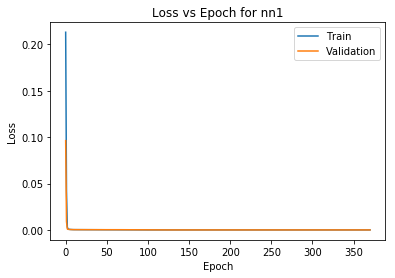

In [14]:
nn1_model,nn1_history=model_trainer('PDFsOnlyTestingLibrary_100x100.hdf5', 'PDFsOnlyModel_100x100_normalized_global_max.hdf5')
plot_loss(data=nn1_history,title="Loss vs Epoch for nn1",yscale='linear')

In [78]:
nn1_results, nn1_actual_values, nn1_labels=model_verifier('PDfsOnlyTestingLibrary_20x20.hdf5','PDFsOnlyModel_100x100.hdf5', nn1_ratios_test,nn1_scint_decays_test)

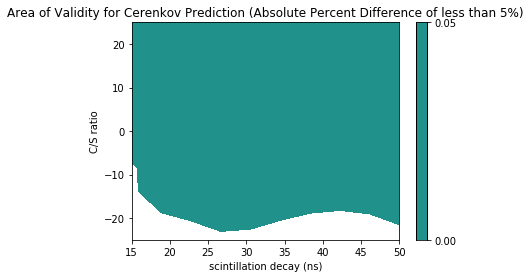

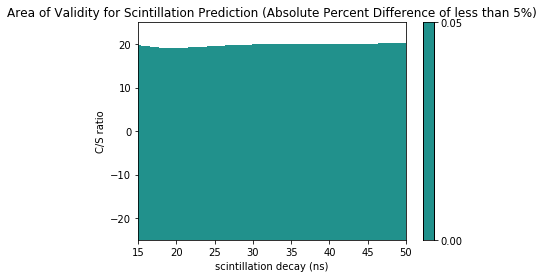

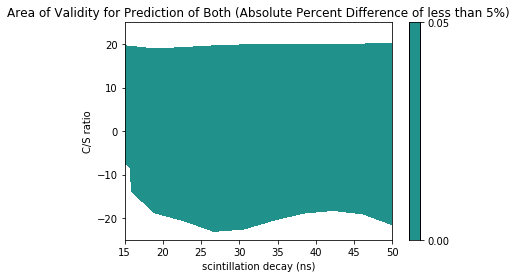

<Figure size 432x288 with 0 Axes>

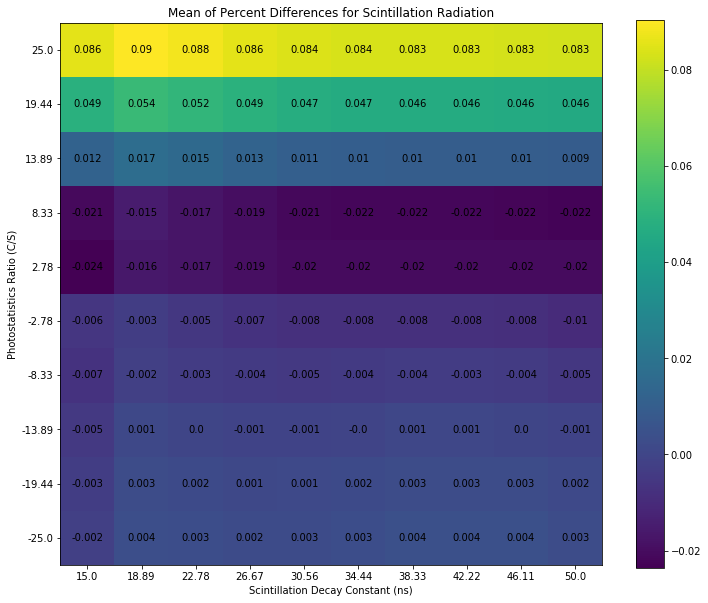

<Figure size 432x288 with 0 Axes>

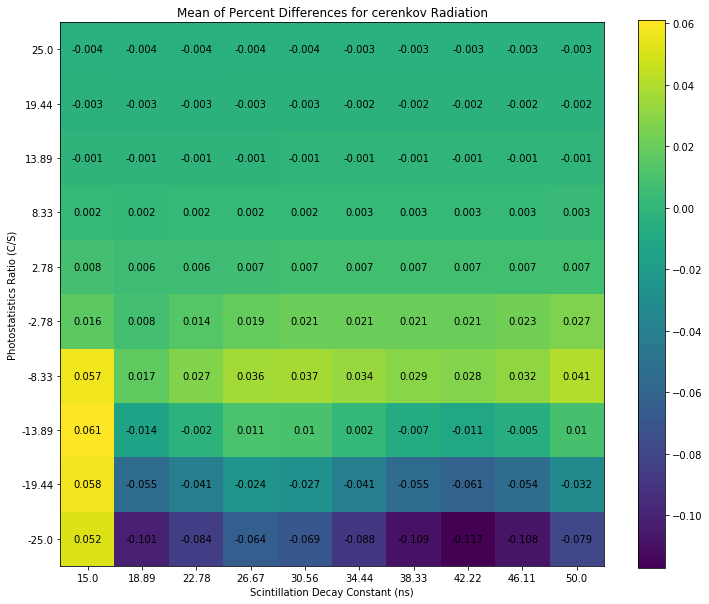

In [79]:
nn1_profile=2*(nn1_results-nn1_actual_values)/(nn1_results+nn1_actual_values)
nn1_sum_to_one=[]
nn1_profile=np.asarray(nn1_profile)
nn1_profile_labels=[]
nn1_profile_cerenkov_mean=[]
nn1_profile_scintillation_mean=[]
nn1_profile_cerenkov_stdev=[]
nn1_profile_scintillation_stdev=[]
for i in range(len(nn1_profile)):
    #print(len([item[0] for item in nn1_profile[i]]))
    nn1_profile_cerenkov_mean.append(np.mean([item[0] for item in nn1_profile[i]]))
    nn1_profile_cerenkov_stdev.append(np.std([item[0] for item in nn1_profile[i]]))
    nn1_profile_scintillation_mean.append(np.mean([item[1] for item in nn1_profile[i]]))
    nn1_profile_scintillation_stdev.append(np.std([item[1] for item in nn1_profile[i]]))
    nn1_profile_labels.append(nn1_labels[i][0])
    nn1_sum_to_one.append(np.mean([item[0]+item[1] for item in nn1_results[i]]))

nn1_profile_labels_clean=[]
for label in nn1_profile_labels:
    index=label.find('/',2)
    #print(label[1:index])
    nn1_profile_labels_clean.append(label[1:index])

nn1_profile_cerenkov_mean=np.asarray(nn1_profile_cerenkov_mean)
nn1_profile_cerenkov_stdev=np.asarray(nn1_profile_cerenkov_stdev)
nn1_profile_scintillation_mean=np.asarray(nn1_profile_scintillation_mean)
nn1_profile_scintillation_stdev=np.asarray(nn1_profile_scintillation_stdev)
nn1_profile_labels_clean=np.asarray(nn1_profile_labels_clean)
nn1_sum_to_one=np.asarray(nn1_sum_to_one)

nn1_profile_cerenkov_mean=np.asarray(nn1_profile_cerenkov_mean.reshape(10,10))
nn1_profile_cerenkov_stdev=np.asarray(nn1_profile_cerenkov_stdev.reshape(10,10))
nn1_profile_scintillation_mean=np.asarray(nn1_profile_scintillation_mean.reshape(10,10))
nn1_profile_scintillation_stdev=np.asarray(nn1_profile_scintillation_stdev.reshape(10,10))
nn1_profile_labels_clean=np.asarray(nn1_profile_labels_clean.reshape(10,10))
nn1_sum_to_one=np.asarray(nn1_sum_to_one.reshape(10,10))


plt.figure()
plot=plt.contourf(nn1_scint_decays_test, nn1_ratios_test, abs(nn1_profile_cerenkov_mean), levels=[0, 0.05])
plt.title("Area of Validity for Cerenkov Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
plot=plt.contourf(nn1_scint_decays_test, nn1_ratios_test, abs(nn1_profile_scintillation_mean), levels=[0, 0.05])
plt.title("Area of Validity for Scintillation Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


nn1_max_error=[]
for cerenkov_vector, scintillation_vector in zip(nn1_profile_cerenkov_mean, nn1_profile_scintillation_mean):
    temp=[]
    for cerenkov_val, scintillation_val in zip(cerenkov_vector, scintillation_vector):
        temp.append(max(abs(cerenkov_val),abs(scintillation_val)))
    nn1_max_error.append(temp)

plt.figure()
plot=plt.contourf(nn1_scint_decays_test, nn1_ratios_test, nn1_max_error , levels=[0, 0.05])
plt.title("Area of Validity for Prediction of Both (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn1_ratios_test)))
ax.set_xticks(np.arange(len(nn1_scint_decays_test)))
ax.set_yticklabels(np.round(nn1_ratios_test,2))
ax.set_xticklabels(np.round(nn1_scint_decays_test,2))
im = ax.imshow(nn1_profile_scintillation_mean)#  extent=(15, 50, 25, -25))
for i in range(len(nn1_ratios_test)):
    for j in range(len(nn1_scint_decays_test)):
        text = plt.text(j, i, round(nn1_profile_scintillation_mean[i, j],3),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn1_ratios_test)))
ax.set_xticks(np.arange(len(nn1_scint_decays_test)))
ax.set_yticklabels(np.round(nn1_ratios_test,2))
ax.set_xticklabels(np.round(nn1_scint_decays_test,2))
im = ax.imshow(nn1_profile_cerenkov_mean)#  extent=(15, 50, 25, -25))
for i in range(len(nn1_ratios_test)):
    for j in range(len(nn1_scint_decays_test)):
        text = plt.text(j, i, round(nn1_profile_cerenkov_mean[i, j],3),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Percent Differences for cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()

In [35]:
print(np.linspace(-25,25,100))

[-25.         -24.49494949 -23.98989899 -23.48484848 -22.97979798
 -22.47474747 -21.96969697 -21.46464646 -20.95959596 -20.45454545
 -19.94949495 -19.44444444 -18.93939394 -18.43434343 -17.92929293
 -17.42424242 -16.91919192 -16.41414141 -15.90909091 -15.4040404
 -14.8989899  -14.39393939 -13.88888889 -13.38383838 -12.87878788
 -12.37373737 -11.86868687 -11.36363636 -10.85858586 -10.35353535
  -9.84848485  -9.34343434  -8.83838384  -8.33333333  -7.82828283
  -7.32323232  -6.81818182  -6.31313131  -5.80808081  -5.3030303
  -4.7979798   -4.29292929  -3.78787879  -3.28282828  -2.77777778
  -2.27272727  -1.76767677  -1.26262626  -0.75757576  -0.25252525
   0.25252525   0.75757576   1.26262626   1.76767677   2.27272727
   2.77777778   3.28282828   3.78787879   4.29292929   4.7979798
   5.3030303    5.80808081   6.31313131   6.81818182   7.32323232
   7.82828283   8.33333333   8.83838384   9.34343434   9.84848485
  10.35353535  10.85858586  11.36363636  11.86868687  12.37373737
  12.87878788

In [38]:
file=h5py.File('PDfsOnlyTestingLibrary_20x20_normalized_max.hdf5', 'r')

In [28]:

X=[]
Y=[]
labels=[]
counter=0
for groups in file.values():

    for subgroup in groups.values():

        for event in subgroup.values():
            if counter<500:
                
                if event.name[-5:]=="input":
                    X.append(event[:])
                    labels.append(event.name)
                elif event.name[-6:]=="output":
                    Y.append(event[:])
                    print(event.name)
                counter+=1
            else:
                break

/ratio-13.88888888888889scintdecay15.0/ratio-13.88888888888889scintdecay15.0/ratio-13.88888888888889scintdecay15.0output
/ratio-13.88888888888889scintdecay18.88888888888889/ratio-13.88888888888889scintdecay18.88888888888889/ratio-13.88888888888889scintdecay18.88888888888889output
/ratio-13.88888888888889scintdecay22.77777777777778/ratio-13.88888888888889scintdecay22.77777777777778/ratio-13.88888888888889scintdecay22.77777777777778output
/ratio-13.88888888888889scintdecay26.666666666666664/ratio-13.88888888888889scintdecay26.666666666666664/ratio-13.88888888888889scintdecay26.666666666666664output
/ratio-13.88888888888889scintdecay30.555555555555557/ratio-13.88888888888889scintdecay30.555555555555557/ratio-13.88888888888889scintdecay30.555555555555557output
/ratio-13.88888888888889scintdecay34.44444444444444/ratio-13.88888888888889scintdecay34.44444444444444/ratio-13.88888888888889scintdecay34.44444444444444output
/ratio-13.88888888888889scintdecay38.33333333333333/ratio-13.888888888888

In [39]:
file.close()

In [30]:
print(counter)

200


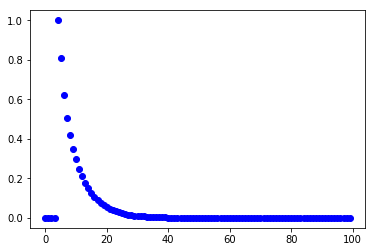

In [31]:
plt.plot(X[0],'bo')


In [22]:
print(Y[0],Y[-1])

[0.43181818 0.56818182] [0.93537415 0.06462585]


In [41]:
print(len(X[0]))

100


In [42]:
print(labels)

['/ratio-0.2525252525252526scintdecay15.0/ratio-0.2525252525252526scintdecay15.0/ratio-0.2525252525252526scintdecay15.0input', '/ratio-0.2525252525252526scintdecay15.353535353535353/ratio-0.2525252525252526scintdecay15.353535353535353/ratio-0.2525252525252526scintdecay15.353535353535353input', '/ratio-0.2525252525252526scintdecay15.707070707070708/ratio-0.2525252525252526scintdecay15.707070707070708/ratio-0.2525252525252526scintdecay15.707070707070708input', '/ratio-0.2525252525252526scintdecay16.060606060606062/ratio-0.2525252525252526scintdecay16.060606060606062/ratio-0.2525252525252526scintdecay16.060606060606062input', '/ratio-0.2525252525252526scintdecay16.414141414141415/ratio-0.2525252525252526scintdecay16.414141414141415/ratio-0.2525252525252526scintdecay16.414141414141415input', '/ratio-0.2525252525252526scintdecay16.767676767676768/ratio-0.2525252525252526scintdecay16.767676767676768/ratio-0.2525252525252526scintdecay16.767676767676768input', '/ratio-0.2525252525252526scintde

In [76]:

print(np.linspace(15,50,100))
print(np.linspace(15,50,20))

[15.         15.35353535 15.70707071 16.06060606 16.41414141 16.76767677
 17.12121212 17.47474747 17.82828283 18.18181818 18.53535354 18.88888889
 19.24242424 19.5959596  19.94949495 20.3030303  20.65656566 21.01010101
 21.36363636 21.71717172 22.07070707 22.42424242 22.77777778 23.13131313
 23.48484848 23.83838384 24.19191919 24.54545455 24.8989899  25.25252525
 25.60606061 25.95959596 26.31313131 26.66666667 27.02020202 27.37373737
 27.72727273 28.08080808 28.43434343 28.78787879 29.14141414 29.49494949
 29.84848485 30.2020202  30.55555556 30.90909091 31.26262626 31.61616162
 31.96969697 32.32323232 32.67676768 33.03030303 33.38383838 33.73737374
 34.09090909 34.44444444 34.7979798  35.15151515 35.50505051 35.85858586
 36.21212121 36.56565657 36.91919192 37.27272727 37.62626263 37.97979798
 38.33333333 38.68686869 39.04040404 39.39393939 39.74747475 40.1010101
 40.45454545 40.80808081 41.16161616 41.51515152 41.86868687 42.22222222
 42.57575758 42.92929293 43.28282828 43.63636364 43.

In [77]:




print(np.linspace(-25,25,100))
print(np.linspace(-25,25,20))

[-25.         -24.49494949 -23.98989899 -23.48484848 -22.97979798
 -22.47474747 -21.96969697 -21.46464646 -20.95959596 -20.45454545
 -19.94949495 -19.44444444 -18.93939394 -18.43434343 -17.92929293
 -17.42424242 -16.91919192 -16.41414141 -15.90909091 -15.4040404
 -14.8989899  -14.39393939 -13.88888889 -13.38383838 -12.87878788
 -12.37373737 -11.86868687 -11.36363636 -10.85858586 -10.35353535
  -9.84848485  -9.34343434  -8.83838384  -8.33333333  -7.82828283
  -7.32323232  -6.81818182  -6.31313131  -5.80808081  -5.3030303
  -4.7979798   -4.29292929  -3.78787879  -3.28282828  -2.77777778
  -2.27272727  -1.76767677  -1.26262626  -0.75757576  -0.25252525
   0.25252525   0.75757576   1.26262626   1.76767677   2.27272727
   2.77777778   3.28282828   3.78787879   4.29292929   4.7979798
   5.3030303    5.80808081   6.31313131   6.81818182   7.32323232
   7.82828283   8.33333333   8.83838384   9.34343434   9.84848485
  10.35353535  10.85858586  11.36363636  11.86868687  12.37373737
  12.87878788

Testing normalized max model to ensure this normalization is feasible

# Normalized Area

In [23]:
nn1_results, nn1_actual_values, nn1_labels=model_verifier('PDfsOnlyTestingLibrary_20x20.hdf5','PDFsOnlyModel_100x100.hdf5', nn1_ratios_test,nn1_scint_decays_test)


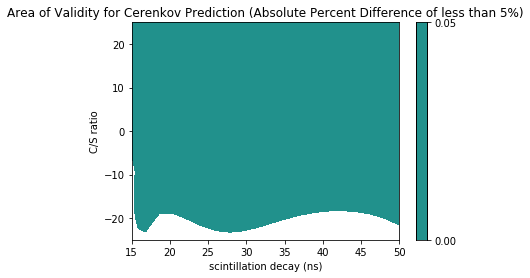

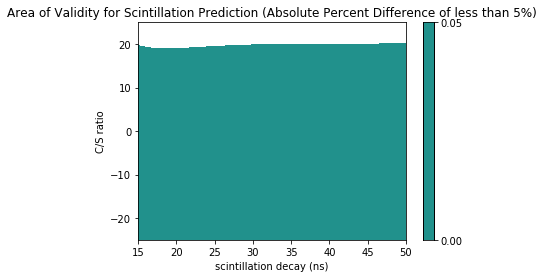

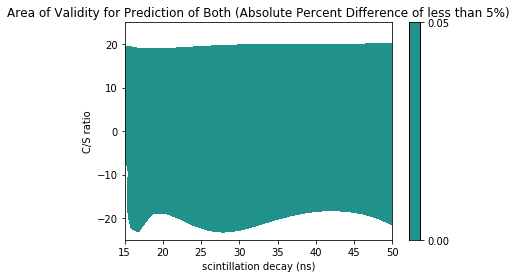

<Figure size 432x288 with 0 Axes>

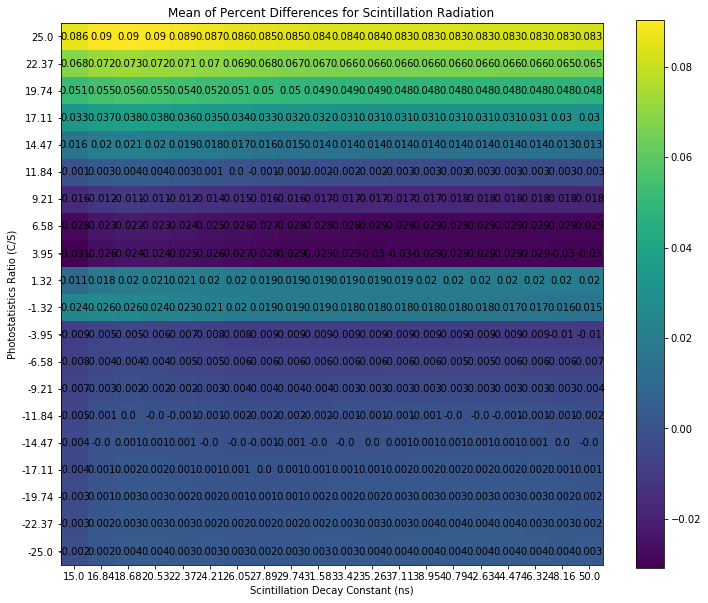

<Figure size 432x288 with 0 Axes>

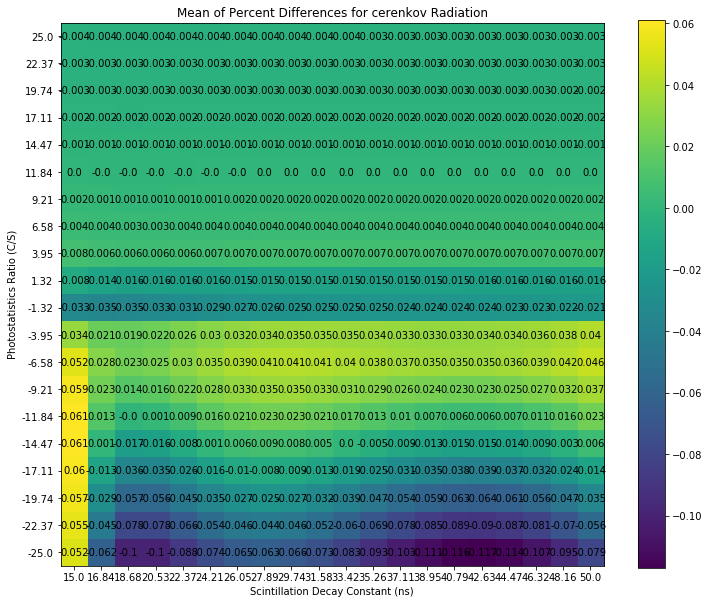

In [24]:

nn1_profile=2*(nn1_results-nn1_actual_values)/(nn1_results+nn1_actual_values)
nn1_sum_to_one=[]
nn1_profile=np.asarray(nn1_profile)
nn1_profile_labels=[]
nn1_profile_cerenkov_mean=[]
nn1_profile_scintillation_mean=[]
nn1_profile_cerenkov_stdev=[]
nn1_profile_scintillation_stdev=[]
for i in range(len(nn1_profile)):
    #print(len([item[0] for item in nn1_profile[i]]))
    nn1_profile_cerenkov_mean.append(np.mean([item[0] for item in nn1_profile[i]]))
    nn1_profile_cerenkov_stdev.append(np.std([item[0] for item in nn1_profile[i]]))
    nn1_profile_scintillation_mean.append(np.mean([item[1] for item in nn1_profile[i]]))
    nn1_profile_scintillation_stdev.append(np.std([item[1] for item in nn1_profile[i]]))
    nn1_profile_labels.append(nn1_labels[i][0])
    nn1_sum_to_one.append(np.mean([item[0]+item[1] for item in nn1_results[i]]))

nn1_profile_labels_clean=[]
for label in nn1_profile_labels:
    index=label.find('/',2)
    #print(label[1:index])
    nn1_profile_labels_clean.append(label[1:index])

nn1_profile_cerenkov_mean=np.asarray(nn1_profile_cerenkov_mean)
nn1_profile_cerenkov_stdev=np.asarray(nn1_profile_cerenkov_stdev)
nn1_profile_scintillation_mean=np.asarray(nn1_profile_scintillation_mean)
nn1_profile_scintillation_stdev=np.asarray(nn1_profile_scintillation_stdev)
nn1_profile_labels_clean=np.asarray(nn1_profile_labels_clean)
nn1_sum_to_one=np.asarray(nn1_sum_to_one)

nn1_profile_cerenkov_mean=np.asarray(nn1_profile_cerenkov_mean.reshape(20,20))
nn1_profile_cerenkov_stdev=np.asarray(nn1_profile_cerenkov_stdev.reshape(20,20))
nn1_profile_scintillation_mean=np.asarray(nn1_profile_scintillation_mean.reshape(20,20))
nn1_profile_scintillation_stdev=np.asarray(nn1_profile_scintillation_stdev.reshape(20,20))
nn1_profile_labels_clean=np.asarray(nn1_profile_labels_clean.reshape(20,20))
nn1_sum_to_one=np.asarray(nn1_sum_to_one.reshape(20,20))


plt.figure()
plot=plt.contourf(nn1_scint_decays_test, nn1_ratios_test, abs(nn1_profile_cerenkov_mean), levels=[0, 0.05])
plt.title("Area of Validity for Cerenkov Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
plot=plt.contourf(nn1_scint_decays_test, nn1_ratios_test, abs(nn1_profile_scintillation_mean), levels=[0, 0.05])
plt.title("Area of Validity for Scintillation Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


nn1_max_error=[]
for cerenkov_vector, scintillation_vector in zip(nn1_profile_cerenkov_mean, nn1_profile_scintillation_mean):
    temp=[]
    for cerenkov_val, scintillation_val in zip(cerenkov_vector, scintillation_vector):
        temp.append(max(abs(cerenkov_val),abs(scintillation_val)))
    nn1_max_error.append(temp)

plt.figure()
plot=plt.contourf(nn1_scint_decays_test, nn1_ratios_test, nn1_max_error , levels=[0, 0.05])
plt.title("Area of Validity for Prediction of Both (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn1_ratios_test)))
ax.set_xticks(np.arange(len(nn1_scint_decays_test)))
ax.set_yticklabels(np.round(nn1_ratios_test,2))
ax.set_xticklabels(np.round(nn1_scint_decays_test,2))
im = ax.imshow(nn1_profile_scintillation_mean)#  extent=(15, 50, 25, -25))
for i in range(len(nn1_ratios_test)):
    for j in range(len(nn1_scint_decays_test)):
        text = plt.text(j, i, round(nn1_profile_scintillation_mean[i, j],3),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn1_ratios_test)))
ax.set_xticks(np.arange(len(nn1_scint_decays_test)))
ax.set_yticklabels(np.round(nn1_ratios_test,2))
ax.set_xticklabels(np.round(nn1_scint_decays_test,2))
im = ax.imshow(nn1_profile_cerenkov_mean)#  extent=(15, 50, 25, -25))
for i in range(len(nn1_ratios_test)):
    for j in range(len(nn1_scint_decays_test)):
        text = plt.text(j, i, round(nn1_profile_cerenkov_mean[i, j],3),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Percent Differences for cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()

# Normalized Max

In [15]:

nn1_scint_decays_test=np.linspace(15,50,20)
nn1_ratios_test=np.linspace(-25,25,20)

nn1_results, nn1_actual_values, nn1_labels=model_verifier('PDfsOnlyTestingLibrary_20x20.hdf5','PDFsOnlyModel_100x100_normalized_global_max.hdf5', nn1_ratios_test,nn1_scint_decays_test)


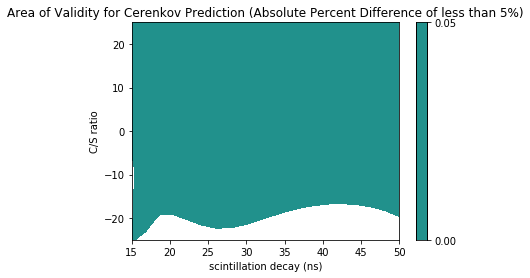

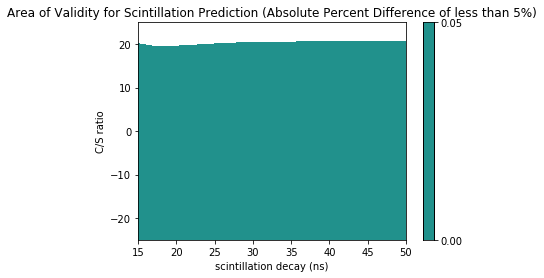

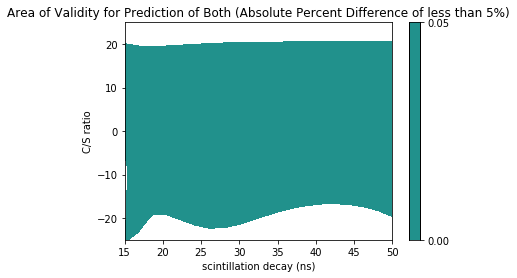

<Figure size 432x288 with 0 Axes>

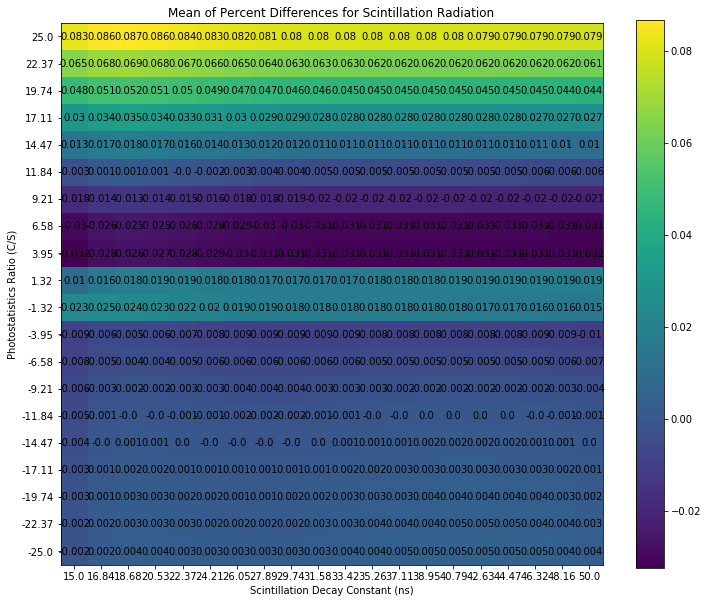

<Figure size 432x288 with 0 Axes>

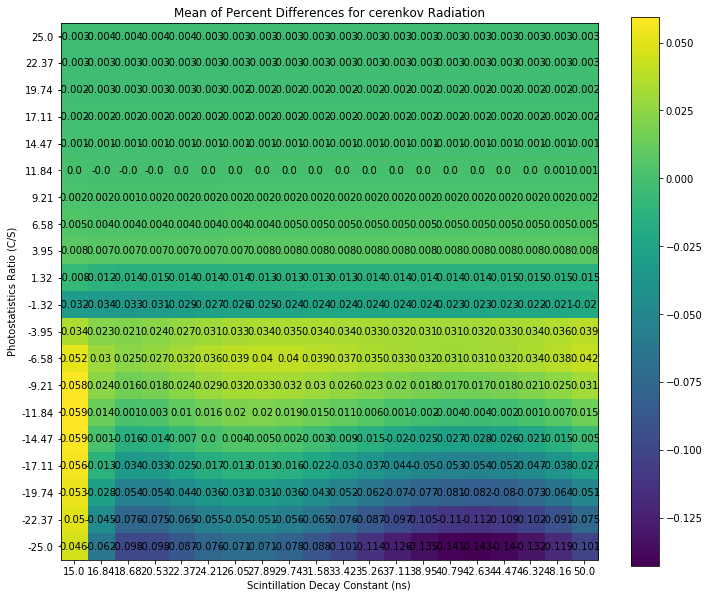

In [16]:

nn1_profile=2*(nn1_results-nn1_actual_values)/(nn1_results+nn1_actual_values)
nn1_sum_to_one=[]
nn1_profile=np.asarray(nn1_profile)
nn1_profile_labels=[]
nn1_profile_cerenkov_mean=[]
nn1_profile_scintillation_mean=[]
nn1_profile_cerenkov_stdev=[]
nn1_profile_scintillation_stdev=[]
for i in range(len(nn1_profile)):
    #print(len([item[0] for item in nn1_profile[i]]))
    nn1_profile_cerenkov_mean.append(np.mean([item[0] for item in nn1_profile[i]]))
    nn1_profile_cerenkov_stdev.append(np.std([item[0] for item in nn1_profile[i]]))
    nn1_profile_scintillation_mean.append(np.mean([item[1] for item in nn1_profile[i]]))
    nn1_profile_scintillation_stdev.append(np.std([item[1] for item in nn1_profile[i]]))
    nn1_profile_labels.append(nn1_labels[i][0])
    nn1_sum_to_one.append(np.mean([item[0]+item[1] for item in nn1_results[i]]))

nn1_profile_labels_clean=[]
for label in nn1_profile_labels:
    index=label.find('/',2)
    #print(label[1:index])
    nn1_profile_labels_clean.append(label[1:index])

nn1_profile_cerenkov_mean=np.asarray(nn1_profile_cerenkov_mean)
nn1_profile_cerenkov_stdev=np.asarray(nn1_profile_cerenkov_stdev)
nn1_profile_scintillation_mean=np.asarray(nn1_profile_scintillation_mean)
nn1_profile_scintillation_stdev=np.asarray(nn1_profile_scintillation_stdev)
nn1_profile_labels_clean=np.asarray(nn1_profile_labels_clean)
nn1_sum_to_one=np.asarray(nn1_sum_to_one)

nn1_profile_cerenkov_mean=np.asarray(nn1_profile_cerenkov_mean.reshape(20,20))
nn1_profile_cerenkov_stdev=np.asarray(nn1_profile_cerenkov_stdev.reshape(20,20))
nn1_profile_scintillation_mean=np.asarray(nn1_profile_scintillation_mean.reshape(20,20))
nn1_profile_scintillation_stdev=np.asarray(nn1_profile_scintillation_stdev.reshape(20,20))
nn1_profile_labels_clean=np.asarray(nn1_profile_labels_clean.reshape(20,20))
nn1_sum_to_one=np.asarray(nn1_sum_to_one.reshape(20,20))


plt.figure()
plot=plt.contourf(nn1_scint_decays_test, nn1_ratios_test, abs(nn1_profile_cerenkov_mean), levels=[0, 0.05])
plt.title("Area of Validity for Cerenkov Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
plot=plt.contourf(nn1_scint_decays_test, nn1_ratios_test, abs(nn1_profile_scintillation_mean), levels=[0, 0.05])
plt.title("Area of Validity for Scintillation Prediction (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


nn1_max_error=[]
for cerenkov_vector, scintillation_vector in zip(nn1_profile_cerenkov_mean, nn1_profile_scintillation_mean):
    temp=[]
    for cerenkov_val, scintillation_val in zip(cerenkov_vector, scintillation_vector):
        temp.append(max(abs(cerenkov_val),abs(scintillation_val)))
    nn1_max_error.append(temp)

plt.figure()
plot=plt.contourf(nn1_scint_decays_test, nn1_ratios_test, nn1_max_error , levels=[0, 0.05])
plt.title("Area of Validity for Prediction of Both (Absolute Percent Difference of less than 5%)")
plt.xlabel("scintillation decay (ns)")
plt.ylabel("C/S ratio")
plt.colorbar()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn1_ratios_test)))
ax.set_xticks(np.arange(len(nn1_scint_decays_test)))
ax.set_yticklabels(np.round(nn1_ratios_test,2))
ax.set_xticklabels(np.round(nn1_scint_decays_test,2))
im = ax.imshow(nn1_profile_scintillation_mean)#  extent=(15, 50, 25, -25))
for i in range(len(nn1_ratios_test)):
    for j in range(len(nn1_scint_decays_test)):
        text = plt.text(j, i, round(nn1_profile_scintillation_mean[i, j],3),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Percent Differences for Scintillation Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()


plt.figure()
fig, ax = plt.subplots()
ax.set_yticks(np.arange(len(nn1_ratios_test)))
ax.set_xticks(np.arange(len(nn1_scint_decays_test)))
ax.set_yticklabels(np.round(nn1_ratios_test,2))
ax.set_xticklabels(np.round(nn1_scint_decays_test,2))
im = ax.imshow(nn1_profile_cerenkov_mean)#  extent=(15, 50, 25, -25))
for i in range(len(nn1_ratios_test)):
    for j in range(len(nn1_scint_decays_test)):
        text = plt.text(j, i, round(nn1_profile_cerenkov_mean[i, j],3),
                       ha="center", va="center", color="black", fontsize=10)
plt.colorbar(im)
plt.title("Mean of Percent Differences for cerenkov Radiation")
plt.xlabel("Scintillation Decay Constant (ns)")
plt.ylabel("Photostatistics Ratio (C/S)")
fig.tight_layout()
fig.set_size_inches(10,10)
plt.gca().invert_yaxis()